In [14]:
# import biblioteka 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [25]:
# ucitavanje i priprema podataka
df = pd.read_csv('power-consumption.csv', sep=',')


# konverzija datetime kolone
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce', format='%m/%d/%Y %H:%M')
df.loc[df['DateTime'].isna(), 'DateTime'] = pd.to_datetime(df['DateTime'][df['DateTime'].isna()], errors='coerce', format='%d-%m-%Y %H:%M')
df = df.dropna(subset=['DateTime'])

# binarne ciljna
# je li potrosnja u Zoni 1 veca od prosjecne?
threshold = df['Zone 1'].median()  
print(threshold)

df['high_consumption'] = (df['Zone 1'] > threshold).astype(int)

df['lag_10min'] = df['Zone 1'].shift(1)
df['lag_30min'] = df['Zone 1'].shift(3)
# df['lag_1h'] = df['Zone 1'].shift(6)
# df['sum_1h'] = df['Zone 1'].rolling(window=6).sum()
df = df.dropna()

32536.70886


In [40]:

X = df[['Temperature', 'Humidity','Wind Speed','lag_10min']]
y = df['high_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=2, shuffle=False)


In [27]:
# skaliranje podataka 

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# kneighbors classifier 

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.9735900673400674


In [29]:
# Decision Tree Klasifikacija

dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))


Decision Tree Accuracy: 0.9724326599326599


In [23]:
# **XGBoost Klasifikacija**
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
num_rounds = 100
model_xgb = xgb.train(params, dtrain, num_rounds)
y_pred_xgb = model_xgb.predict(dtest)
y_pred_xgb = (y_pred_xgb > 0.5).astype(int)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

XGBoost Accuracy: 0.9763


In [41]:
# Neuronska mreža

model_nn = Sequential()
model_nn.add(Dense(input_dim=X_train_scaled.shape[1], units=15))
model_nn.add(Dense(units=35, activation='tanh'))
model_nn.add(Dense(units=20, activation='relu'))
model_nn.add(Dense(units=10, activation='relu'))
model_nn.add(Dense(units=1, activation='sigmoid'))

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_scaled, y_train, batch_size=16, epochs=10)
y_pred_nn = (model_nn.predict(X_test_scaled) > 0.5).astype(int)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step - accuracy: 0.8834 - loss: 0.2722
Epoch 2/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.9692 - loss: 0.0695
Epoch 3/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.9729 - loss: 0.0627
Epoch 4/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - accuracy: 0.9759 - loss: 0.0631
Epoch 5/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.9745 - loss: 0.0609
Epoch 6/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.9724 - loss: 0.0631
Epoch 7/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.9750 - loss: 0.0587
Epoch 8/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.9755 - loss: 0.0616
Epoch 9/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.9769 - loss: 0.0582
Epoch 10/10
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.9753 - loss: 0.0600
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


In [42]:
dropout_model = Sequential()
dropout_model.add(Dense(input_dim=X_train_scaled.shape[1], units=128))
dropout_model.add(Dropout(0.3))
dropout_model.add(Dense(units=64, activation='tanh'))
dropout_model.add(Dropout(0.3))
dropout_model.add(Dense(units=32, activation='relu'))
dropout_model.add(Dropout(0.3))
dropout_model.add(Dense(units=1, activation='sigmoid'))

dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_dropout = dropout_model.fit(X_train_scaled, y_train, batch_size=32, epochs=20)
y_pred_dropout = (dropout_model.predict(X_test_scaled) > 0.5).astype(int)

Epoch 1/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 342us/step - accuracy: 0.8583 - loss: 0.3089
Epoch 2/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9630 - loss: 0.0904
Epoch 3/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.9695 - loss: 0.0731
Epoch 4/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.9705 - loss: 0.0737
Epoch 5/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.9697 - loss: 0.0743
Epoch 6/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.9730 - loss: 0.0632
Epoch 7/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.9721 - loss: 0.0646
Epoch 8/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.9728 - loss: 0.0663
Epoch 9/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.9731 - loss: 0.0653
Epoch 10/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - accuracy: 0.9710 - loss: 0.0684
Epoch 11/20
693/693 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.9731 - loss: 0.0630
Epoch 12/20
693/693 ━━━━━━━━━━

In [39]:
def evaluate_classification(model_name, y_true, y_pred):
    print(f'\n{model_name} Evaluation:')
    print(classification_report(y_true, y_pred))
    print("========================")
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')

# Evaluacija svih modela
evaluate_classification("KNN", y_test, y_pred_knn)
evaluate_classification("Decision Tree", y_test, y_pred_dt)
evaluate_classification("XGBoost", y_test, y_pred_xgb)
evaluate_classification("Neural Network", y_test, y_pred_nn)
evaluate_classification("Neural Network with Dropout", y_test, y_pred_dropout)



KNN Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5917
           1       0.96      0.97      0.97      3587

    accuracy                           0.97      9504
   macro avg       0.97      0.97      0.97      9504
weighted avg       0.97      0.97      0.97      9504

Accuracy: 0.9736

Decision Tree Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5917
           1       0.97      0.95      0.96      3587

    accuracy                           0.97      9504
   macro avg       0.97      0.97      0.97      9504
weighted avg       0.97      0.97      0.97      9504

Accuracy: 0.9724

XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5917
           1       0.97      0.97      0.97      3587

    accuracy                           0.98      9504
   macro avg       0.97      

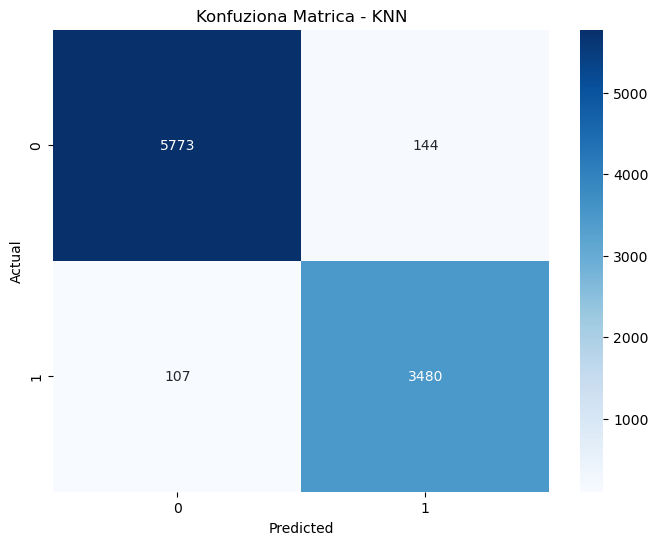

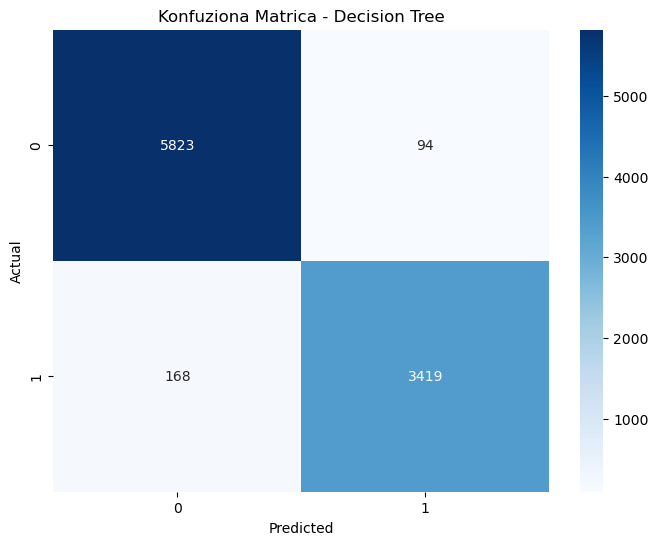

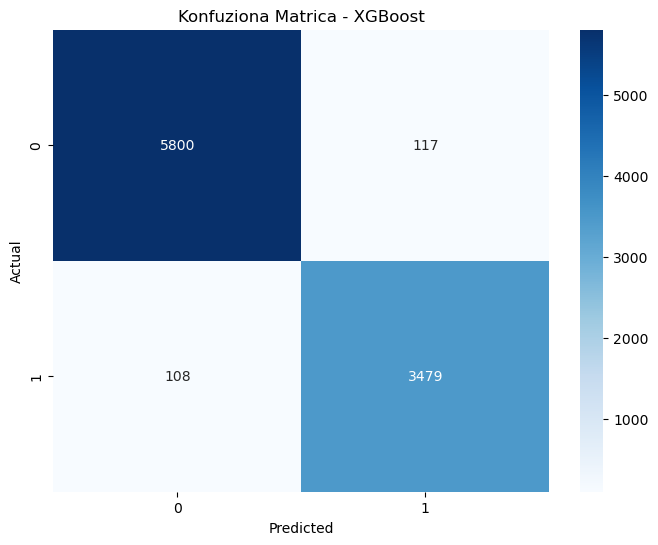

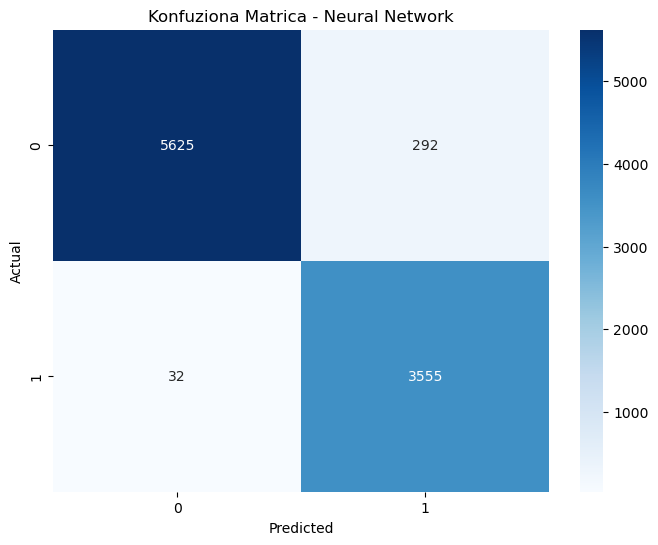

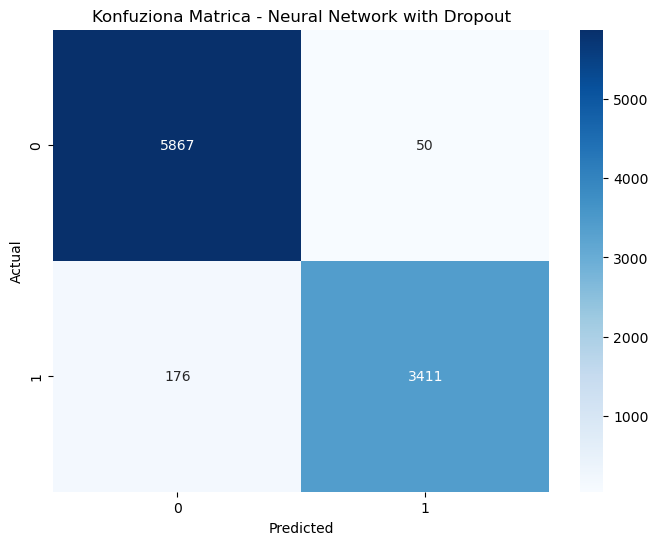

In [31]:
# konfuzione matrice
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred_knn, 'Konfuziona Matrica - KNN')
plot_confusion_matrix(y_test, y_pred_dt, 'Konfuziona Matrica - Decision Tree')
plot_confusion_matrix(y_test, y_pred_xgb, 'Konfuziona Matrica - XGBoost')
plot_confusion_matrix(y_test, y_pred_nn, 'Konfuziona Matrica - Neural Network')
plot_confusion_matrix(y_test, y_pred_dropout, 'Konfuziona Matrica - Neural Network with Dropout')


In [12]:
import joblib
from keras.models import load_model

# Sačuvaj skalere i modele
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

model_nn.save("model_nn.h5")
dropout_model.save("dropout_model.h5")